# Stock Market Trading

## Importar librerias

In [1]:
import math
import numpy as np
import random
import tensorflow as tf
import pandas_datareader as data_reader
import matplotlib.pyplot as plt
import seaborn as sns

#visualizar porcentaje de la tarea
from tqdm import tqdm_notebook, tqdm

#importar experiencia de repeticion
from collections import deque

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
tf.__version__

'2.2.0-rc3'

In [0]:
from matplotlib import style
style.use('ggplot')

## Construir la red de Traider

In [0]:
class AI_Traider():

  '''
  Bot_traider
  @state_size: tamanio de los estados
  @action_space : estaods de nuestro objeto (comprar, vender y no hacer nada)
  '''
  def __init__(self, state_size , action_space=3 , model_name ='AI_Trader'):
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen=2000) #es estatico, estamos reservando una memoria/experiencias
    self.inventory = []
    self.model_name = model_name

    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995

    self.model = self.model_builder()

  '''
    Create model in keras
    @ this model is based in Reinforcement learning
    return model
  '''
  def model_builder(self):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=32, activation='relu' , input_dim=self.state_size))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear')) #valor continuo
    model.compile( optimizer=tf.keras.optimizers.Adam(lr=0.001) , loss='mse')

    return model

  '''
    this function predict the action that the bot have to do.
    return action
  '''
  def trader(self , state):

    if random.random() <= self.epsilon:
      return random.randrange(self.action_space)

    actions = self.model.predict(state)#Devuelve el porcentaje de todas las acciones
    return np.argmax(actions[0]) #me quedo con el maximo

  '''
    This function train the network.
    @Require batch_size of train

  '''
  def batch_train(self , batch_size):

    batch = []

    #analizamos las ultimas posiciones
    for i in range(len(self.memory) - batch_size + 1 , len(self.memory)):
      batch.append(self.memory[i])
    
    #done: estado terminado
    for state, action, reward , next_state, done in batch:
      reward = reward
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #realizamos la ecuacion de berman
      
      target = self.model.predict(state)
      target[0][action] = reward

      self.model.fit(state , target , epochs=1 , verbose=0)

      if self.epsilon > self.epsilon_final:
        self.epsilon *= self.epsilon_decay    #va bajando paulatinamente la exploracion

## Pre Procesado del dataset

### Definir las funciones adisionales

#### Sigmoide

In [0]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

#### Funcion de formato de precios

In [0]:
def stock_price_format(n):
  if n < 0:
    return '- $ {0:3f}'.format(abs(n))
  else:
    return '  $ {0:3f}'.format(abs(n))

#### Carga del dataset

In [0]:
def dataset_loader(stock_name):

  #complete the dataset loader function
  dataset = data_reader.DataReader(stock_name, data_source='yahoo')

  start_date = str(dataset.index[0]).split()[0] #nos da la fecha de inicio
  end_date = str(dataset.index[-1]).split()[0]

  close = dataset['Close']

  return close

#### Ejemplo

In [8]:
dt = data_reader.DataReader('AAPL', data_source = 'yahoo')
dt

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-04-24,130.630005,129.229996,130.490005,130.279999,44525900.0,119.891411
2015-04-27,133.130005,131.149994,132.309998,132.649994,96954200.0,122.072395
2015-04-28,134.539993,129.570007,134.460007,130.559998,118924000.0,120.149078
2015-04-29,131.589996,128.300003,130.160004,128.639999,63386100.0,118.382187
2015-04-30,128.639999,124.580002,128.639999,125.150002,83195400.0,115.170479
...,...,...,...,...,...,...
2020-04-16,288.200012,282.350006,287.380005,286.690002,39281300.0,286.690002
2020-04-17,286.950012,276.859985,284.690002,282.799988,53812500.0,282.799988
2020-04-20,281.679993,276.850006,277.950012,276.929993,32503800.0,276.929993


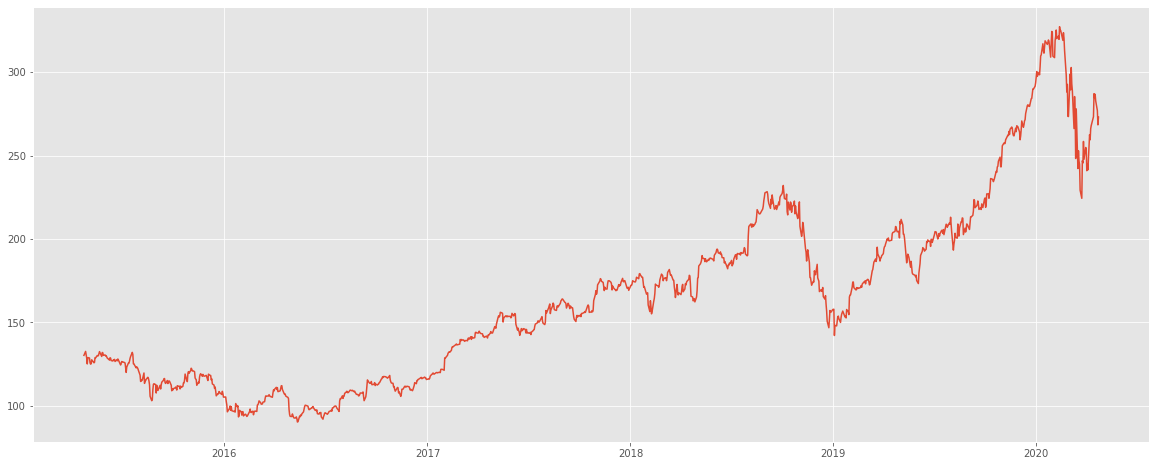

In [21]:
plt.figure(figsize=(20,8))
plt.plot(dt.index,dt['Close'])
plt.show()

#### State Creator

In [0]:
## targets
def state_creator(data , timestep , window_size):

  starting_id = timestep - window_size + 1

  if starting_id >=0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])
  
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
  
  return np.array([state])

## Carga una divisa de mercado

In [0]:
stock_name = 'AAPL'
data = dataset_loader(stock_name)

In [26]:
data.head()

Date
2015-04-24    130.279999
2015-04-27    132.649994
2015-04-28    130.559998
2015-04-29    128.639999
2015-04-30    125.150002
Name: Close, dtype: float64

## Entrenar la AI Trader

### Configurar los hyper parametros

In [0]:
window_size = 10
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

### Definir el modelo del AI Trader

In [0]:
trader = AI_Traider(window_size)
#voy a analizar 10 dias del pasado

In [36]:
trader.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 11,171
Trainable params: 11,171
Non-trainable params: 0
_________________________________________________________________


### Bucle de entrenamiento

In [0]:
for episode in range(1, episodes + 1):

  print('Episodio: {}/{}'.format(episode, episodes))

  state = state_creator(data , 0 , window_size + 1)

  total_profit = 0
  trader.inventory = []

  for t in tqdm(range(data_samples)):

    action = trader.trader(state)

    next_state = state_creator(data, t + 1 , window_size + 1)
    reward = 0

    if action == 1: #compra
      trader.inventory.append(data[t])
      print('AI Trader compro: ',stock_price_format(data[t]))
    
    elif action == 2 and len(trader.inventory) > 0:
      buy_price = trader.inventory.pop(0)

      reward = max(data[t] - buy_price,0)
      total_profit += data[t] - buy_price
      print('AI Trader vendio: ',stock_price_format(data[t]), ' Beneficio: ' + stock_price_format(data[t] - buy_price))
    
    if t == data_samples - 1:
      done = True
    else:
      done = False
    
    trader.memory.append((state, action, reward , next_state , done))

    state = next_state

    if done:
      print('##############')
      print('BENEFICIO TOTAL: ',total_profit)
      print('##############')
    
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)

  if episode % 10 == 0:
    trader.model.save('ai_trader_{}.h5'.format(episode))


  0%|          | 0/1257 [00:00<?, ?it/s]

Episodio: 1/1000
AI Trader compro:  - $ 132.649994
AI Trader vendio:  - $ 130.559998  Beneficio: - $ 2.089996
AI Trader compro:  - $ 125.150002
AI Trader vendio:  - $ 128.949997  Beneficio: - $ 3.799995
AI Trader compro:  - $ 128.699997
AI Trader compro:  - $ 125.800003
AI Trader compro:  - $ 125.010002
AI Trader compro:  - $ 127.620003
AI Trader vendio:  - $ 125.870003  Beneficio: - $ 2.829994
AI Trader vendio:  - $ 128.949997  Beneficio: - $ 3.149994
AI Trader compro:  - $ 130.190002
AI Trader vendio:  - $ 130.070007  Beneficio: - $ 5.060005
AI Trader compro:  - $ 130.059998
AI Trader vendio:  - $ 131.389999  Beneficio: - $ 3.769997
AI Trader compro:  - $ 132.539993
AI Trader vendio:  - $ 129.619995  Beneficio: - $ 0.570007
AI Trader compro:  - $ 131.779999
AI Trader vendio:  - $ 130.279999  Beneficio: - $ 0.220001
AI Trader vendio:  - $ 129.960007  Beneficio: - $ 2.579987
AI Trader vendio:  - $ 130.119995  Beneficio: - $ 1.660004
AI Trader compro:  - $ 127.800003
AI Trader compro:  


  3%|▎         | 34/1257 [00:05<18:25,  1.11it/s]

AI Trader compro:  - $ 127.169998



  3%|▎         | 35/1257 [00:08<28:50,  1.42s/it]

AI Trader vendio:  - $ 126.919998  Beneficio: - $ 0.880005



  3%|▎         | 36/1257 [00:10<35:45,  1.76s/it]

AI Trader vendio:  - $ 127.599998  Beneficio: - $ 1.280006



  3%|▎         | 37/1257 [00:13<41:08,  2.02s/it]

AI Trader compro:  - $ 127.300003



  3%|▎         | 38/1257 [00:16<44:46,  2.20s/it]

AI Trader vendio:  - $ 127.879997  Beneficio: - $ 0.709999



  3%|▎         | 39/1257 [00:18<47:08,  2.32s/it]

AI Trader vendio:  - $ 126.599998  Beneficio: - $ 0.700005



  4%|▎         | 44/1257 [00:31<52:31,  2.60s/it]

AI Trader compro:  - $ 126.750000



  4%|▎         | 45/1257 [00:34<51:25,  2.55s/it]

AI Trader vendio:  - $ 124.529999  Beneficio: - $ 2.220001



  4%|▍         | 53/1257 [00:55<53:03,  2.64s/it]

AI Trader compro:  - $ 123.279999



  4%|▍         | 56/1257 [01:03<53:54,  2.69s/it]

AI Trader vendio:  - $ 126.820000  Beneficio: - $ 3.540001



  5%|▍         | 61/1257 [01:16<53:52,  2.70s/it]

AI Trader compro:  - $ 125.220001



  5%|▍         | 62/1257 [01:19<52:29,  2.64s/it]

AI Trader compro:  - $ 125.160004



  5%|▌         | 64/1257 [01:24<52:46,  2.65s/it]

AI Trader compro:  - $ 122.769997



  5%|▌         | 68/1257 [01:35<52:46,  2.66s/it]

AI Trader compro:  - $ 121.300003



  5%|▌         | 69/1257 [01:38<52:56,  2.67s/it]

AI Trader compro:  - $ 118.440002



  6%|▌         | 70/1257 [01:40<52:14,  2.64s/it]

AI Trader compro:  - $ 114.639999



  6%|▌         | 71/1257 [01:43<52:24,  2.65s/it]

AI Trader compro:  - $ 115.400002



  6%|▌         | 72/1257 [01:45<52:01,  2.63s/it]

AI Trader compro:  - $ 115.129997



  6%|▌         | 73/1257 [01:48<51:58,  2.63s/it]

AI Trader compro:  - $ 115.519997



  6%|▌         | 74/1257 [01:51<52:59,  2.69s/it]

AI Trader vendio:  - $ 119.720001  Beneficio: - $ 5.500000



  6%|▌         | 76/1257 [01:56<52:25,  2.66s/it]

AI Trader compro:  - $ 115.239998



  6%|▌         | 77/1257 [01:59<52:40,  2.68s/it]

AI Trader compro:  - $ 115.150002



  6%|▌         | 78/1257 [02:01<52:02,  2.65s/it]

AI Trader compro:  - $ 115.959999



  6%|▋         | 79/1257 [02:04<51:46,  2.64s/it]

AI Trader compro:  - $ 117.160004



  6%|▋         | 80/1257 [02:06<50:44,  2.59s/it]

AI Trader compro:  - $ 116.500000



  6%|▋         | 81/1257 [02:09<51:12,  2.61s/it]

AI Trader compro:  - $ 115.010002



  7%|▋         | 83/1257 [02:14<51:01,  2.61s/it]

AI Trader compro:  - $ 105.760002



  7%|▋         | 84/1257 [02:17<50:56,  2.61s/it]

AI Trader compro:  - $ 103.120003



  7%|▋         | 85/1257 [02:20<50:41,  2.60s/it]

AI Trader compro:  - $ 103.739998



  7%|▋         | 86/1257 [02:22<51:00,  2.61s/it]

AI Trader compro:  - $ 109.690002



  7%|▋         | 88/1257 [02:27<51:14,  2.63s/it]

AI Trader vendio:  - $ 113.290001  Beneficio: - $ 11.870003



  7%|▋         | 89/1257 [02:30<51:31,  2.65s/it]

AI Trader vendio:  - $ 112.760002  Beneficio: - $ 10.009995



  7%|▋         | 91/1257 [02:36<51:34,  2.65s/it]

AI Trader compro:  - $ 112.339996



  7%|▋         | 92/1257 [02:38<51:12,  2.64s/it]

AI Trader compro:  - $ 110.370003



  7%|▋         | 93/1257 [02:41<51:06,  2.63s/it]

AI Trader compro:  - $ 109.269997



  7%|▋         | 94/1257 [02:44<52:06,  2.69s/it]

AI Trader compro:  - $ 112.309998



  8%|▊         | 96/1257 [02:49<50:42,  2.62s/it]

AI Trader vendio:  - $ 112.570000  Beneficio: - $ 8.730003



  8%|▊         | 97/1257 [02:51<50:25,  2.61s/it]

AI Trader vendio:  - $ 114.209999  Beneficio: - $ 4.230003



  8%|▊         | 98/1257 [02:54<51:23,  2.66s/it]

AI Trader vendio:  - $ 115.309998  Beneficio: - $ 0.669998



  8%|▊         | 100/1257 [03:00<51:53,  2.69s/it]

AI Trader vendio:  - $ 116.410004  Beneficio: - $ 1.010002



  8%|▊         | 102/1257 [03:05<52:21,  2.72s/it]

AI Trader vendio:  - $ 113.449997  Beneficio: - $ 1.680000



  8%|▊         | 103/1257 [03:08<51:45,  2.69s/it]

AI Trader compro:  - $ 115.209999



  8%|▊         | 105/1257 [03:13<50:43,  2.64s/it]

AI Trader compro:  - $ 114.320000



  8%|▊         | 106/1257 [03:15<50:24,  2.63s/it]

AI Trader vendio:  - $ 115.000000  Beneficio: - $ 0.519997



  9%|▊         | 108/1257 [03:21<50:34,  2.64s/it]

AI Trader vendio:  - $ 112.440002  Beneficio: - $ 2.799995



  9%|▊         | 109/1257 [03:23<50:10,  2.62s/it]

AI Trader vendio:  - $ 109.059998  Beneficio: - $ 6.090004



  9%|▉         | 112/1257 [03:32<52:04,  2.73s/it]

AI Trader compro:  - $ 110.379997



  9%|▉         | 113/1257 [03:35<51:48,  2.72s/it]

AI Trader vendio:  - $ 110.779999  Beneficio: - $ 5.180000



  9%|▉         | 116/1257 [03:43<50:53,  2.68s/it]

AI Trader vendio:  - $ 109.500000  Beneficio: - $ 7.660004



  9%|▉         | 117/1257 [03:45<52:18,  2.75s/it]

AI Trader vendio:  - $ 112.120003  Beneficio: - $ 4.379997



  9%|▉         | 119/1257 [03:51<51:00,  2.69s/it]

AI Trader vendio:  - $ 111.790001  Beneficio: - $ 3.220001



 10%|▉         | 123/1257 [04:02<50:58,  2.70s/it]

AI Trader vendio:  - $ 111.730003  Beneficio: - $ 5.970001



 10%|▉         | 124/1257 [04:04<50:22,  2.67s/it]

AI Trader vendio:  - $ 113.769997  Beneficio: - $ 10.649994



 10%|▉         | 125/1257 [04:07<49:43,  2.64s/it]

AI Trader vendio:  - $ 113.760002  Beneficio: - $ 10.020004



 10%|█         | 126/1257 [04:09<49:30,  2.63s/it]

AI Trader vendio:  - $ 115.500000  Beneficio: - $ 5.809998



 10%|█         | 127/1257 [04:12<50:22,  2.67s/it]

AI Trader vendio:  - $ 119.080002  Beneficio: - $ 6.740005



 10%|█         | 128/1257 [04:15<49:32,  2.63s/it]

AI Trader vendio:  - $ 115.279999  Beneficio: - $ 4.909996



 10%|█         | 129/1257 [04:17<48:57,  2.60s/it]

AI Trader vendio:  - $ 114.550003  Beneficio: - $ 5.280006



 10%|█         | 130/1257 [04:20<48:47,  2.60s/it]

AI Trader vendio:  - $ 119.269997  Beneficio: - $ 6.959999



 10%|█         | 131/1257 [04:22<48:40,  2.59s/it]

AI Trader vendio:  - $ 120.529999  Beneficio: - $ 5.320000



 11%|█         | 132/1257 [04:25<49:01,  2.61s/it]

AI Trader vendio:  - $ 119.500000  Beneficio: - $ 5.180000



 11%|█         | 133/1257 [04:28<49:40,  2.65s/it]

AI Trader vendio:  - $ 121.180000  Beneficio: - $ 10.800003



 11%|█         | 138/1257 [04:41<47:59,  2.57s/it]

AI Trader compro:  - $ 120.570000



 11%|█         | 139/1257 [04:43<47:25,  2.55s/it]

AI Trader vendio:  - $ 116.769997  Beneficio: - $ 3.800003



 13%|█▎        | 164/1257 [05:53<56:36,  3.11s/it]

AI Trader compro:  - $ 111.339996



 13%|█▎        | 166/1257 [05:59<55:34,  3.06s/it]

AI Trader vendio:  - $ 106.029999  Beneficio: - $ 5.309998



 14%|█▍        | 178/1257 [06:34<53:14,  2.96s/it]

AI Trader compro:  - $ 96.449997



 14%|█▍        | 179/1257 [06:37<53:25,  2.97s/it]

AI Trader compro:  - $ 96.959999



 14%|█▍        | 181/1257 [06:43<53:41,  2.99s/it]

AI Trader vendio:  - $ 99.959999  Beneficio: - $ 3.510002



 15%|█▍        | 187/1257 [07:01<53:22,  2.99s/it]

AI Trader compro:  - $ 96.300003



 15%|█▌        | 189/1257 [07:07<52:20,  2.94s/it]

AI Trader vendio:  - $ 99.440002  Beneficio: - $ 2.480003



 15%|█▌        | 192/1257 [07:15<49:33,  2.79s/it]

AI Trader compro:  - $ 94.089996



 15%|█▌        | 194/1257 [07:21<51:14,  2.89s/it]

AI Trader compro:  - $ 96.430000



 16%|█▌        | 199/1257 [07:35<48:36,  2.76s/it]

AI Trader compro:  - $ 95.010002



 16%|█▌        | 202/1257 [07:43<46:36,  2.65s/it]

AI Trader compro:  - $ 93.699997



 16%|█▋        | 205/1257 [07:50<45:47,  2.61s/it]

AI Trader vendio:  - $ 98.120003  Beneficio: - $ 1.820000



 17%|█▋        | 210/1257 [08:04<46:40,  2.67s/it]

AI Trader compro:  - $ 96.099998



 17%|█▋        | 214/1257 [08:14<46:04,  2.65s/it]

AI Trader vendio:  - $ 100.529999  Beneficio: - $ 6.440002



 17%|█▋        | 216/1257 [08:20<45:31,  2.62s/it]

AI Trader vendio:  - $ 101.500000  Beneficio: - $ 5.070000



 17%|█▋        | 217/1257 [08:22<45:03,  2.60s/it]

AI Trader vendio:  - $ 103.010002  Beneficio: - $ 8.000000



 18%|█▊        | 220/1257 [08:30<45:10,  2.61s/it]

AI Trader vendio:  - $ 101.120003  Beneficio: - $ 7.420006



 18%|█▊        | 221/1257 [08:33<45:46,  2.65s/it]

AI Trader vendio:  - $ 101.169998  Beneficio: - $ 5.070000



 19%|█▊        | 233/1257 [09:07<45:54,  2.69s/it]

AI Trader compro:  - $ 107.680000



 19%|█▊        | 234/1257 [09:10<46:01,  2.70s/it]

AI Trader vendio:  - $ 109.559998  Beneficio: - $ 1.879997



 20%|█▉        | 250/1257 [09:52<45:42,  2.72s/it]

AI Trader compro:  - $ 105.970001



 20%|█▉        | 251/1257 [09:55<45:15,  2.70s/it]

AI Trader compro:  - $ 105.680000



 20%|██        | 253/1257 [10:00<44:48,  2.68s/it]

AI Trader vendio:  - $ 104.349998  Beneficio: - $ 1.620003



 20%|██        | 255/1257 [10:05<44:18,  2.65s/it]

AI Trader compro:  - $ 94.830002



 20%|██        | 257/1257 [10:11<44:00,  2.64s/it]

AI Trader compro:  - $ 93.639999



 21%|██        | 258/1257 [10:13<43:41,  2.62s/it]

AI Trader compro:  - $ 95.180000



 21%|██        | 259/1257 [10:16<43:59,  2.64s/it]

AI Trader vendio:  - $ 94.190002  Beneficio: - $ 11.489998



 21%|██        | 260/1257 [10:19<45:50,  2.76s/it]

AI Trader vendio:  - $ 93.239998  Beneficio: - $ 1.590004



 21%|██        | 262/1257 [10:25<47:46,  2.88s/it]

AI Trader vendio:  - $ 92.790001  Beneficio: - $ 0.849998



 21%|██        | 263/1257 [10:28<48:32,  2.93s/it]

AI Trader vendio:  - $ 93.419998  Beneficio: - $ 1.760002



 22%|██▏       | 280/1257 [11:17<45:12,  2.78s/it]

AI Trader compro:  - $ 97.919998



 22%|██▏       | 281/1257 [11:19<44:41,  2.75s/it]

AI Trader compro:  - $ 98.629997



 22%|██▏       | 282/1257 [11:22<43:55,  2.70s/it]

AI Trader vendio:  - $ 99.029999  Beneficio: - $ 1.110001



 23%|██▎       | 283/1257 [11:25<43:27,  2.68s/it]

AI Trader vendio:  - $ 98.940002  Beneficio: - $ 0.310005



 25%|██▌       | 316/1257 [12:52<41:36,  2.65s/it]

AI Trader compro:  - $ 96.669998



 25%|██▌       | 317/1257 [12:54<41:38,  2.66s/it]

AI Trader compro:  - $ 102.949997



 25%|██▌       | 318/1257 [12:57<41:45,  2.67s/it]

AI Trader vendio:  - $ 104.339996  Beneficio: - $ 7.669998



 25%|██▌       | 319/1257 [13:00<41:40,  2.67s/it]

AI Trader vendio:  - $ 104.209999  Beneficio: - $ 1.260002



 26%|██▌       | 329/1257 [13:26<40:35,  2.62s/it]

AI Trader compro:  - $ 108.180000



 26%|██▋       | 330/1257 [13:29<40:18,  2.61s/it]

AI Trader compro:  - $ 109.480003



 26%|██▋       | 331/1257 [13:32<40:00,  2.59s/it]

AI Trader compro:  - $ 109.379997



 26%|██▋       | 332/1257 [13:34<39:45,  2.58s/it]

AI Trader compro:  - $ 109.220001



 26%|██▋       | 333/1257 [13:37<41:06,  2.67s/it]

AI Trader vendio:  - $ 109.080002  Beneficio: - $ 0.900002



 27%|██▋       | 334/1257 [13:40<41:37,  2.71s/it]

AI Trader vendio:  - $ 109.360001  Beneficio: - $ 0.120003



 27%|██▋       | 335/1257 [13:43<41:54,  2.73s/it]

AI Trader compro:  - $ 108.510002



 27%|██▋       | 336/1257 [13:45<41:23,  2.70s/it]

AI Trader compro:  - $ 108.849998



 27%|██▋       | 337/1257 [13:48<41:43,  2.72s/it]

AI Trader compro:  - $ 108.029999



 27%|██▋       | 338/1257 [13:51<42:59,  2.81s/it]

AI Trader compro:  - $ 107.570000



 27%|██▋       | 339/1257 [13:54<43:42,  2.86s/it]

AI Trader compro:  - $ 106.940002



 27%|██▋       | 340/1257 [13:57<45:43,  2.99s/it]

AI Trader compro:  - $ 106.820000



 27%|██▋       | 341/1257 [14:00<45:39,  2.99s/it]

AI Trader compro:  - $ 106.000000



 27%|██▋       | 342/1257 [14:03<45:30,  2.98s/it]

AI Trader vendio:  - $ 106.099998  Beneficio: - $ 3.279999



 27%|██▋       | 343/1257 [14:06<45:09,  2.96s/it]

AI Trader vendio:  - $ 106.730003  Beneficio: - $ 2.489998



 27%|██▋       | 344/1257 [14:09<45:08,  2.97s/it]

AI Trader vendio:  - $ 107.730003  Beneficio: - $ 0.779999



 27%|██▋       | 345/1257 [14:12<43:21,  2.85s/it]

AI Trader vendio:  - $ 107.699997  Beneficio: - $ 1.150002



 28%|██▊       | 346/1257 [14:14<41:56,  2.76s/it]

AI Trader vendio:  - $ 108.360001  Beneficio: - $ 0.330002



 28%|██▊       | 349/1257 [14:22<40:12,  2.66s/it]

AI Trader compro:  - $ 105.440002



 28%|██▊       | 350/1257 [14:25<39:37,  2.62s/it]

AI Trader vendio:  - $ 107.949997  Beneficio: - $ 0.379997



 28%|██▊       | 352/1257 [14:30<39:21,  2.61s/it]

AI Trader vendio:  - $ 115.570000  Beneficio: - $ 8.629997



 28%|██▊       | 353/1257 [14:33<39:53,  2.65s/it]

AI Trader vendio:  - $ 114.919998  Beneficio: - $ 8.099998



 28%|██▊       | 357/1257 [14:43<39:11,  2.61s/it]

AI Trader vendio:  - $ 114.620003  Beneficio: - $ 8.620003



 28%|██▊       | 358/1257 [14:46<39:44,  2.65s/it]

AI Trader compro:  - $ 112.709999



 29%|██▊       | 359/1257 [14:49<41:01,  2.74s/it]

AI Trader compro:  - $ 112.879997



 29%|██▊       | 360/1257 [14:52<42:39,  2.85s/it]

AI Trader vendio:  - $ 113.089996  Beneficio: - $ 7.649994



 29%|██▊       | 361/1257 [14:55<42:59,  2.88s/it]

AI Trader vendio:  - $ 113.949997  Beneficio: - $ 1.239998



 29%|██▉       | 362/1257 [14:57<42:23,  2.84s/it]

AI Trader vendio:  - $ 112.180000  Beneficio: - $ 0.699997



 30%|███       | 379/1257 [15:44<37:32,  2.57s/it]

AI Trader compro:  - $ 117.650002



 30%|███       | 380/1257 [15:46<37:52,  2.59s/it]

AI Trader vendio:  - $ 118.250000  Beneficio: - $ 0.599998



 30%|███       | 383/1257 [15:54<37:35,  2.58s/it]

AI Trader compro:  - $ 113.720001



 31%|███       | 384/1257 [15:57<37:58,  2.61s/it]

AI Trader compro:  - $ 113.540001



 31%|███       | 385/1257 [15:59<38:29,  2.65s/it]

AI Trader compro:  - $ 111.489998



 31%|███       | 386/1257 [16:02<39:44,  2.74s/it]

AI Trader compro:  - $ 111.589996



 31%|███       | 387/1257 [16:06<42:18,  2.92s/it]

AI Trader vendio:  - $ 109.830002  Beneficio: - $ 3.889999



 31%|███       | 388/1257 [16:08<40:44,  2.81s/it]

AI Trader vendio:  - $ 108.839996  Beneficio: - $ 4.700005



 31%|███       | 389/1257 [16:11<39:38,  2.74s/it]

AI Trader compro:  - $ 110.410004



 31%|███       | 390/1257 [16:14<39:41,  2.75s/it]

AI Trader vendio:  - $ 111.059998  Beneficio: - $ 0.430000



 31%|███       | 391/1257 [16:16<39:04,  2.71s/it]

AI Trader vendio:  - $ 110.879997  Beneficio: - $ 0.709999



 31%|███▏      | 395/1257 [16:27<38:13,  2.66s/it]

AI Trader compro:  - $ 107.110001



 32%|███▏      | 396/1257 [16:29<37:34,  2.62s/it]

AI Trader vendio:  - $ 109.989998  Beneficio: - $ 0.420006



 32%|███▏      | 397/1257 [16:32<37:08,  2.59s/it]

AI Trader vendio:  - $ 109.949997  Beneficio: - $ 2.839996



 32%|███▏      | 402/1257 [16:44<36:18,  2.55s/it]

AI Trader compro:  - $ 111.790001



 32%|███▏      | 408/1257 [17:01<39:20,  2.78s/it]

AI Trader vendio:  - $ 109.110001  Beneficio: - $ 2.680000



 33%|███▎      | 409/1257 [17:05<41:50,  2.96s/it]

AI Trader compro:  - $ 109.949997



 33%|███▎      | 410/1257 [17:07<41:01,  2.91s/it]

AI Trader vendio:  - $ 111.029999  Beneficio: - $ 1.080002



 33%|███▎      | 413/1257 [17:15<38:29,  2.74s/it]

AI Trader compro:  - $ 113.300003



 33%|███▎      | 414/1257 [17:18<37:44,  2.69s/it]

AI Trader compro:  - $ 115.190002



 33%|███▎      | 415/1257 [17:20<37:58,  2.71s/it]

AI Trader compro:  - $ 115.190002



 33%|███▎      | 416/1257 [17:23<37:30,  2.68s/it]

AI Trader vendio:  - $ 115.820000  Beneficio: - $ 2.519997



 33%|███▎      | 417/1257 [17:26<37:24,  2.67s/it]

AI Trader compro:  - $ 115.970001



 33%|███▎      | 418/1257 [17:28<37:04,  2.65s/it]

AI Trader compro:  - $ 116.639999



 34%|███▎      | 423/1257 [17:42<37:26,  2.69s/it]

AI Trader compro:  - $ 117.260002



 34%|███▎      | 424/1257 [17:45<37:35,  2.71s/it]

AI Trader compro:  - $ 116.760002



 34%|███▍      | 425/1257 [17:47<37:40,  2.72s/it]

AI Trader compro:  - $ 116.730003



 34%|███▍      | 426/1257 [17:51<40:13,  2.90s/it]

AI Trader vendio:  - $ 115.820000  Beneficio: - $ 0.629997



 34%|███▍      | 427/1257 [17:54<40:41,  2.94s/it]

AI Trader compro:  - $ 116.150002



 34%|███▍      | 429/1257 [18:00<39:56,  2.89s/it]

AI Trader compro:  - $ 116.610001



 34%|███▍      | 430/1257 [18:03<40:48,  2.96s/it]

AI Trader compro:  - $ 117.910004



 34%|███▍      | 431/1257 [18:06<40:34,  2.95s/it]

AI Trader vendio:  - $ 118.989998  Beneficio: - $ 3.799995



 34%|███▍      | 432/1257 [18:08<40:24,  2.94s/it]

AI Trader compro:  - $ 119.110001



 34%|███▍      | 433/1257 [18:11<39:55,  2.91s/it]

AI Trader compro:  - $ 119.750000



 35%|███▍      | 434/1257 [18:14<38:27,  2.80s/it]

AI Trader compro:  - $ 119.250000



 35%|███▍      | 435/1257 [18:16<37:27,  2.73s/it]

AI Trader compro:  - $ 119.040001



 35%|███▍      | 436/1257 [18:19<36:50,  2.69s/it]

AI Trader compro:  - $ 120.000000



 35%|███▍      | 437/1257 [18:22<37:31,  2.75s/it]

AI Trader vendio:  - $ 119.989998  Beneficio: - $ 4.019997



 35%|███▍      | 438/1257 [18:25<37:59,  2.78s/it]

AI Trader vendio:  - $ 119.779999  Beneficio: - $ 3.139999



 35%|███▍      | 439/1257 [18:28<38:12,  2.80s/it]

AI Trader vendio:  - $ 120.000000  Beneficio: - $ 2.739998



 35%|███▌      | 440/1257 [18:30<36:57,  2.71s/it]

AI Trader vendio:  - $ 120.080002  Beneficio: - $ 3.320000



 35%|███▌      | 441/1257 [18:33<36:30,  2.68s/it]

AI Trader vendio:  - $ 119.970001  Beneficio: - $ 3.239998



 35%|███▌      | 442/1257 [18:35<36:05,  2.66s/it]

AI Trader vendio:  - $ 121.879997  Beneficio: - $ 5.729996



 35%|███▌      | 443/1257 [18:38<35:46,  2.64s/it]

AI Trader vendio:  - $ 121.940002  Beneficio: - $ 5.330002



 35%|███▌      | 444/1257 [18:40<35:01,  2.59s/it]

AI Trader vendio:  - $ 121.949997  Beneficio: - $ 4.039993



 35%|███▌      | 446/1257 [18:46<35:22,  2.62s/it]

AI Trader vendio:  - $ 121.349998  Beneficio: - $ 2.239998



 36%|███▌      | 447/1257 [18:48<34:59,  2.59s/it]

AI Trader vendio:  - $ 128.750000  Beneficio: - $ 9.000000



 36%|███▌      | 448/1257 [18:51<34:48,  2.58s/it]

AI Trader vendio:  - $ 128.529999  Beneficio: - $ 9.279999



 36%|███▌      | 449/1257 [18:54<35:42,  2.65s/it]

AI Trader compro:  - $ 129.080002



 36%|███▌      | 450/1257 [18:56<34:57,  2.60s/it]

AI Trader compro:  - $ 130.289993



 36%|███▌      | 451/1257 [18:59<35:50,  2.67s/it]

AI Trader compro:  - $ 131.529999



 36%|███▌      | 453/1257 [19:05<38:49,  2.90s/it]

AI Trader vendio:  - $ 132.419998  Beneficio: - $ 13.379997



 36%|███▌      | 454/1257 [19:08<38:47,  2.90s/it]

AI Trader vendio:  - $ 132.119995  Beneficio: - $ 12.119995



 36%|███▌      | 455/1257 [19:11<38:54,  2.91s/it]

AI Trader vendio:  - $ 133.289993  Beneficio: - $ 4.209991



 36%|███▋      | 456/1257 [19:14<38:56,  2.92s/it]

AI Trader vendio:  - $ 135.020004  Beneficio: - $ 4.730011



 36%|███▋      | 457/1257 [19:17<39:06,  2.93s/it]

AI Trader vendio:  - $ 135.509995  Beneficio: - $ 3.979996



 37%|███▋      | 463/1257 [19:35<38:44,  2.93s/it]

AI Trader compro:  - $ 136.660004



 37%|███▋      | 464/1257 [19:37<37:28,  2.84s/it]

AI Trader vendio:  - $ 136.929993  Beneficio: - $ 0.269989



 39%|███▊      | 485/1257 [20:37<35:36,  2.77s/it]

AI Trader compro:  - $ 143.800003



 40%|███▉      | 499/1257 [21:19<37:47,  2.99s/it]

AI Trader vendio:  - $ 141.199997  Beneficio: - $ 2.600006



 43%|████▎     | 543/1257 [23:26<35:40,  3.00s/it]

AI Trader compro:  - $ 145.009995



 43%|████▎     | 544/1257 [23:29<35:40,  3.00s/it]

AI Trader compro:  - $ 145.869995



 43%|████▎     | 545/1257 [23:32<35:38,  3.00s/it]

AI Trader compro:  - $ 145.630005



 49%|████▊     | 611/1257 [26:37<28:47,  2.67s/it]

AI Trader vendio:  - $ 153.139999  Beneficio: - $ 8.130005



 49%|████▊     | 612/1257 [26:39<29:21,  2.73s/it]

AI Trader vendio:  - $ 154.229996  Beneficio: - $ 8.360001



 49%|████▉     | 613/1257 [26:42<29:12,  2.72s/it]

AI Trader vendio:  - $ 153.279999  Beneficio: - $ 7.649994



 78%|███████▊  | 975/1257 [43:13<12:27,  2.65s/it]

AI Trader compro:  - $ 178.899994



 78%|███████▊  | 977/1257 [43:18<12:16,  2.63s/it]

AI Trader vendio:  - $ 181.710007  Beneficio: - $ 2.810013



 78%|███████▊  | 985/1257 [43:40<12:16,  2.71s/it]

AI Trader compro:  - $ 188.740005



 78%|███████▊  | 986/1257 [43:42<12:07,  2.69s/it]

AI Trader compro:  - $ 186.789993



 79%|███████▊  | 987/1257 [43:45<12:06,  2.69s/it]

AI Trader compro:  - $ 188.470001



 79%|███████▊  | 988/1257 [43:48<12:02,  2.68s/it]

AI Trader compro:  - $ 188.720001



 79%|███████▊  | 989/1257 [43:51<12:15,  2.74s/it]

AI Trader compro:  - $ 189.949997



 79%|███████▉  | 990/1257 [43:53<12:16,  2.76s/it]

AI Trader compro:  - $ 191.240005



 79%|███████▉  | 991/1257 [43:56<12:19,  2.78s/it]

AI Trader compro:  - $ 194.020004



 79%|███████▉  | 992/1257 [43:59<12:10,  2.76s/it]

AI Trader compro:  - $ 195.350006



 79%|███████▉  | 993/1257 [44:01<11:53,  2.70s/it]

AI Trader compro:  - $ 195.690002



 79%|███████▉  | 995/1257 [44:07<11:31,  2.64s/it]

AI Trader compro:  - $ 200.100006



 79%|███████▉  | 996/1257 [44:09<11:27,  2.63s/it]

AI Trader vendio:  - $ 199.500000  Beneficio: - $ 10.759995



 79%|███████▉  | 997/1257 [44:12<11:22,  2.62s/it]

AI Trader vendio:  - $ 200.619995  Beneficio: - $ 13.830002



 79%|███████▉  | 998/1257 [44:15<11:29,  2.66s/it]

AI Trader vendio:  - $ 198.949997  Beneficio: - $ 10.479996



 79%|███████▉  | 999/1257 [44:17<11:18,  2.63s/it]

AI Trader vendio:  - $ 198.869995  Beneficio: - $ 10.149994



 80%|███████▉  | 1000/1257 [44:20<11:15,  2.63s/it]

AI Trader vendio:  - $ 199.229996  Beneficio: - $ 9.279999



 80%|███████▉  | 1001/1257 [44:23<11:18,  2.65s/it]

AI Trader vendio:  - $ 199.250000  Beneficio: - $ 8.009995



 80%|███████▉  | 1002/1257 [44:25<11:17,  2.66s/it]

AI Trader vendio:  - $ 203.130005  Beneficio: - $ 9.110001



 80%|███████▉  | 1003/1257 [44:28<11:09,  2.64s/it]

AI Trader vendio:  - $ 203.860001  Beneficio: - $ 8.509995



 80%|███████▉  | 1004/1257 [44:31<11:19,  2.68s/it]

AI Trader vendio:  - $ 204.529999  Beneficio: - $ 8.839996



 80%|███████▉  | 1005/1257 [44:33<11:11,  2.66s/it]

AI Trader vendio:  - $ 207.479996  Beneficio: - $ 7.379990



 81%|████████  | 1021/1257 [45:15<10:09,  2.58s/it]

AI Trader compro:  - $ 190.919998



 81%|████████▏ | 1023/1257 [45:20<10:10,  2.61s/it]

AI Trader vendio:  - $ 189.000000  Beneficio: - $ 1.919998



 83%|████████▎ | 1049/1257 [46:32<09:31,  2.75s/it]

AI Trader compro:  - $ 195.570007



 84%|████████▎ | 1050/1257 [46:34<09:31,  2.76s/it]

AI Trader vendio:  - $ 199.800003  Beneficio: - $ 4.229996



 84%|████████▎ | 1052/1257 [46:40<09:24,  2.75s/it]

AI Trader compro:  - $ 197.919998



 84%|████████▍ | 1053/1257 [46:42<09:12,  2.71s/it]

AI Trader vendio:  - $ 201.550003  Beneficio: - $ 3.630005



 84%|████████▍ | 1055/1257 [46:48<09:30,  2.82s/it]

AI Trader compro:  - $ 204.410004



 84%|████████▍ | 1056/1257 [46:51<09:31,  2.85s/it]

AI Trader compro:  - $ 204.229996



 84%|████████▍ | 1057/1257 [46:54<09:47,  2.94s/it]

AI Trader compro:  - $ 200.020004



 84%|████████▍ | 1058/1257 [46:57<09:36,  2.90s/it]

AI Trader compro:  - $ 201.240005



 84%|████████▍ | 1059/1257 [47:00<09:31,  2.88s/it]

AI Trader compro:  - $ 203.229996



 84%|████████▍ | 1060/1257 [47:03<09:23,  2.86s/it]

AI Trader vendio:  - $ 201.750000  Beneficio: - $ 2.660004



 84%|████████▍ | 1061/1257 [47:06<09:19,  2.85s/it]

AI Trader vendio:  - $ 203.300003  Beneficio: - $ 0.929993



 84%|████████▍ | 1062/1257 [47:08<09:06,  2.80s/it]

AI Trader vendio:  - $ 205.210007  Beneficio: - $ 5.190002



 85%|████████▍ | 1063/1257 [47:11<08:50,  2.74s/it]

AI Trader vendio:  - $ 204.500000  Beneficio: - $ 3.259995



 85%|████████▍ | 1064/1257 [47:14<09:01,  2.80s/it]

AI Trader compro:  - $ 203.350006



 85%|████████▍ | 1065/1257 [47:17<08:59,  2.81s/it]

AI Trader vendio:  - $ 205.660004  Beneficio: - $ 2.430008



 85%|████████▍ | 1066/1257 [47:19<08:53,  2.79s/it]

AI Trader compro:  - $ 202.589996



 85%|████████▍ | 1067/1257 [47:22<08:46,  2.77s/it]

AI Trader compro:  - $ 207.220001



 85%|████████▍ | 1068/1257 [47:25<08:44,  2.78s/it]

AI Trader vendio:  - $ 208.839996  Beneficio: - $ 5.489990



 85%|████████▌ | 1069/1257 [47:28<08:41,  2.77s/it]

AI Trader vendio:  - $ 208.669998  Beneficio: - $ 6.080002



 85%|████████▌ | 1070/1257 [47:31<08:39,  2.78s/it]

AI Trader compro:  - $ 207.020004



 85%|████████▌ | 1071/1257 [47:34<08:48,  2.84s/it]

AI Trader compro:  - $ 207.740005



 85%|████████▌ | 1072/1257 [47:36<08:42,  2.83s/it]

AI Trader vendio:  - $ 209.679993  Beneficio: - $ 2.459991



 85%|████████▌ | 1073/1257 [47:39<08:42,  2.84s/it]

AI Trader compro:  - $ 208.779999



 85%|████████▌ | 1074/1257 [47:42<08:37,  2.83s/it]

AI Trader vendio:  - $ 213.039993  Beneficio: - $ 6.019989



 86%|████████▌ | 1075/1257 [47:45<08:30,  2.80s/it]

AI Trader compro:  - $ 208.429993



 86%|████████▌ | 1076/1257 [47:47<08:22,  2.78s/it]

AI Trader compro:  - $ 204.020004



 86%|████████▌ | 1077/1257 [47:50<08:30,  2.84s/it]

AI Trader compro:  - $ 193.339996



 86%|████████▌ | 1078/1257 [47:53<08:18,  2.79s/it]

AI Trader vendio:  - $ 197.000000  Beneficio: - $ 10.740005



 86%|████████▌ | 1079/1257 [47:56<08:02,  2.71s/it]

AI Trader vendio:  - $ 199.039993  Beneficio: - $ 9.740005



 86%|████████▌ | 1080/1257 [47:58<08:02,  2.73s/it]

AI Trader vendio:  - $ 203.429993  Beneficio: - $ 5.000000



 86%|████████▌ | 1081/1257 [48:01<08:03,  2.75s/it]

AI Trader vendio:  - $ 200.990005  Beneficio: - $ 3.029999



 86%|████████▌ | 1082/1257 [48:04<08:02,  2.76s/it]

AI Trader compro:  - $ 200.479996



 86%|████████▌ | 1083/1257 [48:07<08:06,  2.79s/it]

AI Trader compro:  - $ 208.970001



 86%|████████▌ | 1084/1257 [48:10<08:15,  2.86s/it]

AI Trader compro:  - $ 202.750000



 86%|████████▋ | 1085/1257 [48:13<08:07,  2.83s/it]

AI Trader compro:  - $ 201.740005



 86%|████████▋ | 1086/1257 [48:15<08:05,  2.84s/it]

AI Trader vendio:  - $ 206.500000  Beneficio: - $ 13.160004



 86%|████████▋ | 1087/1257 [48:18<08:00,  2.83s/it]

AI Trader vendio:  - $ 210.350006  Beneficio: - $ 9.870010



 87%|████████▋ | 1088/1257 [48:21<07:48,  2.77s/it]

AI Trader compro:  - $ 210.360001



 87%|████████▋ | 1089/1257 [48:23<07:35,  2.71s/it]

AI Trader vendio:  - $ 212.639999  Beneficio: - $ 3.669998



 87%|████████▋ | 1090/1257 [48:26<07:34,  2.72s/it]

AI Trader vendio:  - $ 212.460007  Beneficio: - $ 9.710007



 87%|████████▋ | 1091/1257 [48:29<07:18,  2.64s/it]

AI Trader compro:  - $ 202.639999



 87%|████████▋ | 1092/1257 [48:31<06:59,  2.54s/it]

AI Trader compro:  - $ 206.490005



 87%|████████▋ | 1093/1257 [48:33<06:48,  2.49s/it]

AI Trader vendio:  - $ 204.160004  Beneficio: - $ 2.419998



 87%|████████▋ | 1094/1257 [48:36<06:37,  2.44s/it]

AI Trader compro:  - $ 205.529999



 87%|████████▋ | 1095/1257 [48:38<06:32,  2.42s/it]

AI Trader vendio:  - $ 209.009995  Beneficio: - $ 1.350006



 87%|████████▋ | 1096/1257 [48:40<06:29,  2.42s/it]

AI Trader vendio:  - $ 208.740005  Beneficio: - $ 6.100006



 87%|████████▋ | 1097/1257 [48:43<06:35,  2.47s/it]

AI Trader vendio:  - $ 205.699997  Beneficio: - $ 0.790009



 87%|████████▋ | 1098/1257 [48:45<06:28,  2.44s/it]

AI Trader vendio:  - $ 209.190002  Beneficio: - $ 3.660004



 88%|████████▊ | 1100/1257 [48:50<06:16,  2.40s/it]

AI Trader compro:  - $ 213.259995



 88%|████████▊ | 1101/1257 [48:53<06:11,  2.38s/it]

AI Trader vendio:  - $ 214.169998  Beneficio: - $ 0.910004



 88%|████████▊ | 1104/1257 [49:00<06:09,  2.42s/it]

AI Trader compro:  - $ 223.089996



 88%|████████▊ | 1105/1257 [49:02<06:04,  2.40s/it]

AI Trader vendio:  - $ 218.750000  Beneficio: - $ 4.339996



 88%|████████▊ | 1108/1257 [49:09<05:55,  2.39s/it]

AI Trader compro:  - $ 222.770004



 88%|████████▊ | 1109/1257 [49:12<05:54,  2.39s/it]

AI Trader vendio:  - $ 220.960007  Beneficio: - $ 1.809998



 88%|████████▊ | 1112/1257 [49:19<05:47,  2.40s/it]

AI Trader compro:  - $ 217.679993



 89%|████████▊ | 1113/1257 [49:21<05:44,  2.39s/it]

AI Trader compro:  - $ 221.029999



 89%|████████▊ | 1114/1257 [49:24<05:42,  2.39s/it]

AI Trader vendio:  - $ 219.889999  Beneficio: - $ 2.210007



 89%|████████▊ | 1115/1257 [49:26<05:41,  2.41s/it]

AI Trader vendio:  - $ 218.820007  Beneficio: - $ 2.209991



 89%|████████▉ | 1117/1257 [49:31<05:49,  2.50s/it]

AI Trader compro:  - $ 224.589996



 89%|████████▉ | 1118/1257 [49:34<05:47,  2.50s/it]

AI Trader compro:  - $ 218.960007



 89%|████████▉ | 1119/1257 [49:36<05:42,  2.48s/it]

AI Trader vendio:  - $ 220.820007  Beneficio: - $ 3.769989



 89%|████████▉ | 1120/1257 [49:39<05:35,  2.45s/it]

AI Trader vendio:  - $ 227.009995  Beneficio: - $ 8.049988



 89%|████████▉ | 1121/1257 [49:41<05:31,  2.44s/it]

AI Trader compro:  - $ 227.059998



 89%|████████▉ | 1122/1257 [49:43<05:27,  2.42s/it]

AI Trader vendio:  - $ 224.399994  Beneficio: - $ 2.660004



 89%|████████▉ | 1125/1257 [49:51<05:22,  2.45s/it]

AI Trader compro:  - $ 236.210007



 90%|████████▉ | 1126/1257 [49:53<05:17,  2.42s/it]

AI Trader vendio:  - $ 235.869995  Beneficio: - $ 0.340012



 90%|████████▉ | 1129/1257 [50:00<05:07,  2.41s/it]

AI Trader compro:  - $ 235.279999



 90%|████████▉ | 1130/1257 [50:03<05:14,  2.48s/it]

AI Trader vendio:  - $ 236.410004  Beneficio: - $ 1.130005



 91%|█████████ | 1144/1257 [50:40<05:06,  2.71s/it]

AI Trader compro:  - $ 259.429993



 91%|█████████ | 1145/1257 [50:42<05:00,  2.69s/it]

AI Trader vendio:  - $ 260.140015  Beneficio: - $ 0.710022



 92%|█████████▏| 1153/1257 [51:03<04:33,  2.63s/it]

AI Trader compro:  - $ 263.190002



 92%|█████████▏| 1154/1257 [51:06<04:30,  2.62s/it]

AI Trader vendio:  - $ 262.010010  Beneficio: - $ 1.179993



 92%|█████████▏| 1156/1257 [51:11<04:24,  2.62s/it]

AI Trader compro:  - $ 266.369995



 92%|█████████▏| 1157/1257 [51:14<04:30,  2.70s/it]

AI Trader vendio:  - $ 264.290009  Beneficio: - $ 2.079987



 92%|█████████▏| 1160/1257 [51:22<04:17,  2.65s/it]

AI Trader compro:  - $ 264.160004



 92%|█████████▏| 1161/1257 [51:25<04:12,  2.63s/it]

AI Trader compro:  - $ 259.450012



 92%|█████████▏| 1162/1257 [51:27<04:07,  2.61s/it]

AI Trader vendio:  - $ 261.739990  Beneficio: - $ 2.420013



 93%|█████████▎| 1163/1257 [51:30<04:08,  2.65s/it]

AI Trader vendio:  - $ 265.579987  Beneficio: - $ 6.129974



 93%|█████████▎| 1168/1257 [51:43<03:52,  2.61s/it]

AI Trader compro:  - $ 271.459991



 93%|█████████▎| 1169/1257 [51:45<03:50,  2.62s/it]

AI Trader vendio:  - $ 275.149994  Beneficio: - $ 3.690002



 93%|█████████▎| 1174/1257 [51:59<03:38,  2.63s/it]

AI Trader compro:  - $ 279.440002



 93%|█████████▎| 1175/1257 [52:01<03:36,  2.64s/it]

AI Trader vendio:  - $ 284.000000  Beneficio: - $ 4.559998



 94%|█████████▍| 1185/1257 [52:28<03:09,  2.63s/it]

AI Trader compro:  - $ 303.190002



 94%|█████████▍| 1186/1257 [52:30<03:05,  2.61s/it]

AI Trader vendio:  - $ 309.630005  Beneficio: - $ 6.440002



 95%|█████████▍| 1190/1257 [52:41<02:57,  2.65s/it]

AI Trader compro:  - $ 311.339996



 95%|█████████▍| 1191/1257 [52:44<02:55,  2.65s/it]

AI Trader compro:  - $ 315.239990



 95%|█████████▍| 1192/1257 [52:46<02:50,  2.62s/it]

AI Trader vendio:  - $ 318.730011  Beneficio: - $ 7.390015



 95%|█████████▍| 1193/1257 [52:49<02:46,  2.60s/it]

AI Trader compro:  - $ 316.570007



 95%|█████████▍| 1194/1257 [52:51<02:43,  2.60s/it]

AI Trader vendio:  - $ 317.700012  Beneficio: - $ 2.460022



 95%|█████████▌| 1195/1257 [52:54<02:41,  2.61s/it]

AI Trader vendio:  - $ 319.230011  Beneficio: - $ 2.660004



 95%|█████████▌| 1196/1257 [52:57<02:39,  2.62s/it]

AI Trader compro:  - $ 318.309998



 95%|█████████▌| 1197/1257 [52:59<02:39,  2.65s/it]

AI Trader compro:  - $ 308.950012



 95%|█████████▌| 1198/1257 [53:02<02:35,  2.64s/it]

AI Trader vendio:  - $ 317.690002  Beneficio: - $ 0.619995



 95%|█████████▌| 1199/1257 [53:04<02:32,  2.62s/it]

AI Trader vendio:  - $ 324.339996  Beneficio: - $ 15.389984



 95%|█████████▌| 1200/1257 [53:07<02:29,  2.62s/it]

AI Trader compro:  - $ 323.869995



 96%|█████████▌| 1201/1257 [53:10<02:26,  2.62s/it]

AI Trader vendio:  - $ 309.510010  Beneficio: - $ 14.359985



 96%|█████████▌| 1202/1257 [53:12<02:23,  2.61s/it]

AI Trader compro:  - $ 308.660004



 96%|█████████▌| 1203/1257 [53:15<02:25,  2.69s/it]

AI Trader vendio:  - $ 318.850006  Beneficio: - $ 10.190002



 96%|█████████▌| 1208/1257 [53:28<02:08,  2.62s/it]

AI Trader compro:  - $ 319.609985



 96%|█████████▌| 1209/1257 [53:31<02:05,  2.61s/it]

AI Trader compro:  - $ 327.200012



 96%|█████████▋| 1210/1257 [53:33<02:03,  2.64s/it]

AI Trader vendio:  - $ 324.869995  Beneficio: - $ 5.260010



 96%|█████████▋| 1211/1257 [53:36<02:00,  2.62s/it]

AI Trader vendio:  - $ 324.950012  Beneficio: - $ 2.250000



 97%|█████████▋| 1215/1257 [53:47<01:51,  2.66s/it]

AI Trader compro:  - $ 313.049988



 97%|█████████▋| 1216/1257 [53:50<01:50,  2.70s/it]

AI Trader vendio:  - $ 298.179993  Beneficio: - $ 14.869995



 97%|█████████▋| 1217/1257 [53:52<01:47,  2.68s/it]

AI Trader compro:  - $ 288.079987



 97%|█████████▋| 1218/1257 [53:55<01:43,  2.66s/it]

AI Trader vendio:  - $ 292.649994  Beneficio: - $ 4.570007



 97%|█████████▋| 1222/1257 [54:05<01:31,  2.62s/it]

AI Trader compro:  - $ 289.320007



 97%|█████████▋| 1223/1257 [54:08<01:30,  2.66s/it]

AI Trader compro:  - $ 302.739990



 97%|█████████▋| 1224/1257 [54:11<01:27,  2.64s/it]

AI Trader vendio:  - $ 292.920013  Beneficio: - $ 3.600006



 97%|█████████▋| 1225/1257 [54:13<01:25,  2.66s/it]

AI Trader compro:  - $ 289.029999



 98%|█████████▊| 1226/1257 [54:16<01:21,  2.62s/it]

AI Trader compro:  - $ 266.170013



 98%|█████████▊| 1227/1257 [54:18<01:18,  2.62s/it]

AI Trader vendio:  - $ 285.339996  Beneficio: - $ 17.399994



 98%|█████████▊| 1228/1257 [54:21<01:15,  2.60s/it]

AI Trader vendio:  - $ 275.429993  Beneficio: - $ 13.600006



 98%|█████████▊| 1229/1257 [54:24<01:12,  2.59s/it]

AI Trader compro:  - $ 248.229996



 98%|█████████▊| 1230/1257 [54:26<01:11,  2.65s/it]

AI Trader vendio:  - $ 277.970001  Beneficio: - $ 11.799988



 98%|█████████▊| 1231/1257 [54:29<01:08,  2.64s/it]

AI Trader vendio:  - $ 242.210007  Beneficio: - $ 6.019989



 98%|█████████▊| 1232/1257 [54:32<01:05,  2.63s/it]

AI Trader compro:  - $ 252.860001



 98%|█████████▊| 1233/1257 [54:34<01:03,  2.64s/it]

AI Trader vendio:  - $ 246.669998  Beneficio: - $ 6.190002



 98%|█████████▊| 1234/1257 [54:37<01:01,  2.67s/it]

AI Trader compro:  - $ 244.779999



 98%|█████████▊| 1235/1257 [54:40<00:58,  2.66s/it]

AI Trader compro:  - $ 229.240005



 98%|█████████▊| 1236/1257 [54:43<00:57,  2.72s/it]

AI Trader compro:  - $ 224.369995



 98%|█████████▊| 1237/1257 [54:45<00:53,  2.67s/it]

AI Trader vendio:  - $ 246.880005  Beneficio: - $ 2.100006



 98%|█████████▊| 1238/1257 [54:48<00:50,  2.63s/it]

AI Trader compro:  - $ 245.520004



 99%|█████████▊| 1239/1257 [54:50<00:47,  2.63s/it]

AI Trader vendio:  - $ 258.440002  Beneficio: - $ 29.199997



 99%|█████████▊| 1240/1257 [54:53<00:44,  2.62s/it]

AI Trader vendio:  - $ 247.740005  Beneficio: - $ 23.370010



 99%|█████████▊| 1241/1257 [54:55<00:41,  2.61s/it]

AI Trader compro:  - $ 254.809998



 99%|█████████▉| 1242/1257 [54:58<00:39,  2.61s/it]

AI Trader vendio:  - $ 254.289993  Beneficio: - $ 8.769989



 99%|█████████▉| 1243/1257 [55:01<00:37,  2.68s/it]

AI Trader compro:  - $ 240.910004



 99%|█████████▉| 1244/1257 [55:03<00:34,  2.63s/it]

AI Trader vendio:  - $ 244.929993  Beneficio: - $ 9.880005



 99%|█████████▉| 1245/1257 [55:06<00:31,  2.60s/it]

AI Trader vendio:  - $ 241.410004  Beneficio: - $ 0.500000



 99%|█████████▉| 1247/1257 [55:11<00:25,  2.58s/it]

AI Trader compro:  - $ 259.429993



 99%|█████████▉| 1248/1257 [55:14<00:23,  2.59s/it]

AI Trader vendio:  - $ 266.070007  Beneficio: - $ 6.640015



100%|█████████▉| 1254/1257 [55:29<00:07,  2.59s/it]

AI Trader compro:  - $ 282.799988



100%|█████████▉| 1255/1257 [55:32<00:05,  2.59s/it]

AI Trader vendio:  - $ 276.929993  Beneficio: - $ 5.869995



100%|█████████▉| 1256/1257 [55:35<00:02,  2.64s/it]

AI Trader compro:  - $ 268.369995
##############
BENEFICIO TOTAL:  383.02999114990234
##############



100%|██████████| 1257/1257 [55:37<00:00,  2.66s/it]

  0%|          | 0/1257 [00:00<?, ?it/s]

Episodio: 2/1000



  1%|          | 11/1257 [00:28<53:22,  2.57s/it]

AI Trader compro:  - $ 126.320000



  1%|          | 12/1257 [00:30<53:31,  2.58s/it]

AI Trader vendio:  - $ 125.870003  Beneficio: - $ 0.449997



  6%|▌         | 78/1257 [03:22<50:35,  2.58s/it]

AI Trader compro:  - $ 115.959999



  6%|▋         | 79/1257 [03:25<50:21,  2.56s/it]

AI Trader vendio:  - $ 117.160004  Beneficio: - $ 1.200005



  9%|▊         | 108/1257 [04:41<51:01,  2.66s/it]

AI Trader compro:  - $ 112.440002



  9%|▊         | 109/1257 [04:43<51:43,  2.70s/it]

AI Trader compro:  - $ 109.059998



  9%|▉         | 110/1257 [04:46<51:57,  2.72s/it]

AI Trader vendio:  - $ 110.300003  Beneficio: - $ 2.139999



  9%|▉         | 111/1257 [04:49<52:30,  2.75s/it]

AI Trader vendio:  - $ 109.580002  Beneficio: - $ 0.520004



 10%|█         | 131/1257 [05:46<53:14,  2.84s/it]

AI Trader compro:  - $ 120.529999



 11%|█         | 132/1257 [05:49<53:18,  2.84s/it]

AI Trader vendio:  - $ 119.500000  Beneficio: - $ 1.029999



 11%|█         | 136/1257 [06:00<51:03,  2.73s/it]

AI Trader compro:  - $ 120.919998



 11%|█         | 137/1257 [06:03<50:43,  2.72s/it]

AI Trader vendio:  - $ 121.059998  Beneficio: - $ 0.139999



 11%|█         | 139/1257 [06:08<51:35,  2.77s/it]

AI Trader compro:  - $ 116.769997



 11%|█         | 140/1257 [06:11<52:02,  2.80s/it]

AI Trader compro:  - $ 116.110001



 11%|█         | 141/1257 [06:14<52:25,  2.82s/it]

AI Trader vendio:  - $ 115.720001  Beneficio: - $ 1.049995



 11%|█▏        | 142/1257 [06:17<51:55,  2.79s/it]

AI Trader compro:  - $ 112.339996



 11%|█▏        | 143/1257 [06:20<51:55,  2.80s/it]

AI Trader vendio:  - $ 114.180000  Beneficio: - $ 1.930000



 11%|█▏        | 144/1257 [06:22<51:37,  2.78s/it]

AI Trader vendio:  - $ 113.690002  Beneficio: - $ 1.350006



 12%|█▏        | 145/1257 [06:25<51:40,  2.79s/it]

AI Trader compro:  - $ 117.290001



 12%|█▏        | 146/1257 [06:28<52:45,  2.85s/it]

AI Trader vendio:  - $ 118.779999  Beneficio: - $ 1.489998



 12%|█▏        | 151/1257 [06:42<52:27,  2.85s/it]

AI Trader compro:  - $ 117.809998



 12%|█▏        | 152/1257 [06:45<52:36,  2.86s/it]

AI Trader vendio:  - $ 118.300003  Beneficio: - $ 0.490005



 12%|█▏        | 155/1257 [06:54<52:21,  2.85s/it]

AI Trader compro:  - $ 115.199997



 12%|█▏        | 156/1257 [06:56<51:00,  2.78s/it]

AI Trader vendio:  - $ 119.029999  Beneficio: - $ 3.830002



 12%|█▏        | 157/1257 [06:59<49:55,  2.72s/it]

AI Trader compro:  - $ 118.279999



 13%|█▎        | 158/1257 [07:02<48:58,  2.67s/it]

AI Trader compro:  - $ 118.230003



 13%|█▎        | 159/1257 [07:04<49:19,  2.70s/it]

AI Trader vendio:  - $ 115.620003  Beneficio: - $ 2.659996



 13%|█▎        | 160/1257 [07:07<49:17,  2.70s/it]

AI Trader compro:  - $ 116.169998



 13%|█▎        | 161/1257 [07:10<49:37,  2.72s/it]

AI Trader compro:  - $ 113.180000



 13%|█▎        | 162/1257 [07:13<50:01,  2.74s/it]

AI Trader vendio:  - $ 112.480003  Beneficio: - $ 5.750000



 13%|█▎        | 163/1257 [07:15<50:22,  2.76s/it]

AI Trader vendio:  - $ 110.489998  Beneficio: - $ 5.680000



 13%|█▎        | 164/1257 [07:18<50:39,  2.78s/it]

AI Trader vendio:  - $ 111.339996  Beneficio: - $ 1.840004



 13%|█▎        | 166/1257 [07:24<51:21,  2.82s/it]

AI Trader compro:  - $ 106.029999



 13%|█▎        | 167/1257 [07:27<50:53,  2.80s/it]

AI Trader vendio:  - $ 107.330002  Beneficio: - $ 1.300003



 13%|█▎        | 168/1257 [07:29<50:29,  2.78s/it]

AI Trader compro:  - $ 107.230003



 13%|█▎        | 169/1257 [07:32<49:38,  2.74s/it]

AI Trader vendio:  - $ 108.610001  Beneficio: - $ 1.379997



 14%|█▎        | 171/1257 [07:37<47:57,  2.65s/it]

AI Trader compro:  - $ 106.820000



 14%|█▎        | 172/1257 [07:40<49:18,  2.73s/it]

AI Trader vendio:  - $ 108.739998  Beneficio: - $ 1.919998



 14%|█▍        | 173/1257 [07:43<49:36,  2.75s/it]

AI Trader compro:  - $ 107.320000



 14%|█▍        | 174/1257 [07:46<49:26,  2.74s/it]

AI Trader compro:  - $ 105.260002



 14%|█▍        | 175/1257 [07:48<49:34,  2.75s/it]

AI Trader vendio:  - $ 105.349998  Beneficio: - $ 1.970001



 14%|█▍        | 176/1257 [07:51<49:24,  2.74s/it]

AI Trader vendio:  - $ 102.709999  Beneficio: - $ 2.550003



 14%|█▍        | 177/1257 [07:54<49:17,  2.74s/it]

AI Trader compro:  - $ 100.699997



 14%|█▍        | 178/1257 [07:57<49:23,  2.75s/it]

AI Trader compro:  - $ 96.449997



 14%|█▍        | 179/1257 [08:00<50:58,  2.84s/it]

AI Trader vendio:  - $ 96.959999  Beneficio: - $ 3.739998



 14%|█▍        | 180/1257 [08:02<50:25,  2.81s/it]

AI Trader vendio:  - $ 98.529999  Beneficio: - $ 2.080002



 15%|█▍        | 185/1257 [08:16<50:03,  2.80s/it]

AI Trader compro:  - $ 96.660004



 15%|█▍        | 186/1257 [08:19<50:53,  2.85s/it]

AI Trader vendio:  - $ 96.790001  Beneficio: - $ 0.129997



 15%|█▌        | 192/1257 [08:36<50:58,  2.87s/it]

AI Trader compro:  - $ 94.089996



 15%|█▌        | 193/1257 [08:39<50:34,  2.85s/it]

AI Trader vendio:  - $ 97.339996  Beneficio: - $ 3.250000



 16%|█▌        | 198/1257 [08:53<50:08,  2.84s/it]

AI Trader compro:  - $ 94.019997



 16%|█▌        | 199/1257 [08:56<50:50,  2.88s/it]

AI Trader vendio:  - $ 95.010002  Beneficio: - $ 0.990005



 16%|█▌        | 201/1257 [09:02<49:50,  2.83s/it]

AI Trader compro:  - $ 94.269997



 16%|█▌        | 202/1257 [09:05<49:44,  2.83s/it]

AI Trader vendio:  - $ 93.699997  Beneficio: - $ 0.570000



 19%|█▉        | 237/1257 [10:46<49:44,  2.93s/it]

AI Trader compro:  - $ 111.120003



 19%|█▉        | 238/1257 [10:48<48:27,  2.85s/it]

AI Trader vendio:  - $ 109.809998  Beneficio: - $ 1.310005



 19%|█▉        | 241/1257 [10:57<48:16,  2.85s/it]

AI Trader compro:  - $ 108.660004



 19%|█▉        | 242/1257 [11:00<47:29,  2.81s/it]

AI Trader vendio:  - $ 109.019997  Beneficio: - $ 0.359993



 19%|█▉        | 243/1257 [11:02<46:52,  2.77s/it]

AI Trader compro:  - $ 110.440002



 19%|█▉        | 244/1257 [11:05<46:42,  2.77s/it]

AI Trader vendio:  - $ 112.040001  Beneficio: - $ 1.599998



 20%|█▉        | 247/1257 [11:13<46:47,  2.78s/it]

AI Trader compro:  - $ 107.480003



 20%|█▉        | 248/1257 [11:16<46:19,  2.75s/it]

AI Trader compro:  - $ 106.910004



 20%|█▉        | 249/1257 [11:19<46:07,  2.75s/it]

AI Trader vendio:  - $ 107.129997  Beneficio: - $ 0.350006



 20%|█▉        | 250/1257 [11:22<45:49,  2.73s/it]

AI Trader vendio:  - $ 105.970001  Beneficio: - $ 0.940002



 20%|██        | 254/1257 [11:33<46:12,  2.76s/it]

AI Trader compro:  - $ 97.820000



 20%|██        | 255/1257 [11:35<45:37,  2.73s/it]

AI Trader compro:  - $ 94.830002



 21%|██        | 258/1257 [11:43<45:04,  2.71s/it]

AI Trader vendio:  - $ 95.180000  Beneficio: - $ 2.639999



 21%|██        | 261/1257 [11:52<46:50,  2.82s/it]

AI Trader vendio:  - $ 92.720001  Beneficio: - $ 2.110001



 21%|██        | 265/1257 [12:04<47:06,  2.85s/it]

AI Trader compro:  - $ 90.339996



 21%|██        | 266/1257 [12:07<47:55,  2.90s/it]

AI Trader compro:  - $ 90.519997



 21%|██        | 267/1257 [12:09<47:24,  2.87s/it]

AI Trader vendio:  - $ 93.879997  Beneficio: - $ 3.540001



 21%|██▏       | 268/1257 [12:12<47:01,  2.85s/it]

AI Trader vendio:  - $ 93.489998  Beneficio: - $ 2.970001



 22%|██▏       | 275/1257 [12:32<44:44,  2.73s/it]

AI Trader compro:  - $ 100.410004



 22%|██▏       | 276/1257 [12:34<44:21,  2.71s/it]

AI Trader compro:  - $ 100.349998



 22%|██▏       | 277/1257 [12:37<44:38,  2.73s/it]

AI Trader vendio:  - $ 99.860001  Beneficio: - $ 0.550003



 22%|██▏       | 278/1257 [12:40<45:16,  2.77s/it]

AI Trader vendio:  - $ 98.459999  Beneficio: - $ 1.889999



 23%|██▎       | 285/1257 [13:00<45:18,  2.80s/it]

AI Trader compro:  - $ 98.830002



 23%|██▎       | 286/1257 [13:03<46:16,  2.86s/it]

AI Trader compro:  - $ 97.339996



 23%|██▎       | 287/1257 [13:05<45:52,  2.84s/it]

AI Trader compro:  - $ 97.459999



 23%|██▎       | 288/1257 [13:08<46:02,  2.85s/it]

AI Trader vendio:  - $ 97.139999  Beneficio: - $ 1.690002



 23%|██▎       | 289/1257 [13:11<45:52,  2.84s/it]

AI Trader vendio:  - $ 97.550003  Beneficio: - $ 0.210007



 23%|██▎       | 290/1257 [13:14<46:12,  2.87s/it]

AI Trader compro:  - $ 95.330002



 23%|██▎       | 291/1257 [13:17<46:14,  2.87s/it]

AI Trader compro:  - $ 95.099998



 23%|██▎       | 292/1257 [13:20<47:52,  2.98s/it]

AI Trader vendio:  - $ 95.910004  Beneficio: - $ 1.549995



 23%|██▎       | 293/1257 [13:23<47:44,  2.97s/it]

AI Trader vendio:  - $ 95.550003  Beneficio: - $ 0.220001



 23%|██▎       | 294/1257 [13:26<47:55,  2.99s/it]

AI Trader vendio:  - $ 96.099998  Beneficio: - $ 1.000000



 23%|██▎       | 295/1257 [13:29<47:48,  2.98s/it]

AI Trader compro:  - $ 93.400002



 24%|██▎       | 296/1257 [13:32<47:43,  2.98s/it]

AI Trader compro:  - $ 92.040001



 24%|██▎       | 297/1257 [13:35<47:40,  2.98s/it]

AI Trader compro:  - $ 93.589996



 24%|██▎       | 298/1257 [13:38<47:23,  2.97s/it]

AI Trader vendio:  - $ 94.400002  Beneficio: - $ 1.000000



 24%|██▍       | 299/1257 [13:41<48:09,  3.02s/it]

AI Trader vendio:  - $ 95.599998  Beneficio: - $ 3.559998



 24%|██▍       | 300/1257 [13:44<47:24,  2.97s/it]

AI Trader vendio:  - $ 95.889999  Beneficio: - $ 2.300003



 24%|██▍       | 301/1257 [13:47<46:51,  2.94s/it]

AI Trader compro:  - $ 94.989998



 24%|██▍       | 302/1257 [13:50<46:32,  2.92s/it]

AI Trader compro:  - $ 95.529999



 24%|██▍       | 303/1257 [13:53<46:34,  2.93s/it]

AI Trader vendio:  - $ 95.940002  Beneficio: - $ 0.950005



 24%|██▍       | 304/1257 [13:55<46:10,  2.91s/it]

AI Trader vendio:  - $ 96.680000  Beneficio: - $ 1.150002



 25%|██▍       | 308/1257 [14:07<44:42,  2.83s/it]

AI Trader compro:  - $ 98.790001



 25%|██▍       | 309/1257 [14:10<44:15,  2.80s/it]

AI Trader vendio:  - $ 98.779999  Beneficio: - $ 0.010002



 25%|██▍       | 310/1257 [14:12<43:51,  2.78s/it]

AI Trader compro:  - $ 99.830002



 25%|██▍       | 311/1257 [14:15<43:32,  2.76s/it]

AI Trader vendio:  - $ 99.870003  Beneficio: - $ 0.040001



 25%|██▍       | 312/1257 [14:18<44:33,  2.83s/it]

AI Trader compro:  - $ 99.959999



 25%|██▍       | 313/1257 [14:21<43:59,  2.80s/it]

AI Trader vendio:  - $ 99.430000  Beneficio: - $ 0.529999



 25%|██▍       | 314/1257 [14:23<43:23,  2.76s/it]

AI Trader compro:  - $ 98.660004



 25%|██▌       | 315/1257 [14:26<43:26,  2.77s/it]

AI Trader compro:  - $ 97.339996



 25%|██▌       | 316/1257 [14:29<43:01,  2.74s/it]

AI Trader compro:  - $ 96.669998



 25%|██▌       | 317/1257 [14:32<43:45,  2.79s/it]

AI Trader vendio:  - $ 102.949997  Beneficio: - $ 4.289993
